# Implementing back propogation

In [10]:
import numpy as np
import PIL
from numpy import asarray
from PIL  import Image
import math
import matplotlib.pyplot as plt
import os
import nltk
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import PCA
import random
from sklearn.feature_extraction.text import TfidfVectorizer
import ntpath
import sys
from scipy.special import softmax

In [11]:
#Placing the input images into numpy array
Data = []       
happy_img = []
sad_img = []
N = 0
n_happy = 0
n_sad = 0
directory = r"C:\Users\Yashi Sahu\Desktop\mlsp4\Data\emotion_classification\train"
for filename in os.scandir(directory):
    if filename.is_file():
        filename2 = directory + "\\" + ntpath.basename(filename)
        img = Image.open(filename2).resize((100,100))
        npImg = np.array(img)
        flatArray = np.transpose(np.ravel(npImg))
        x = ntpath.basename(filename).split(".")
        if x[1] == "happy":
            happy_img.append(list(flatArray))
            n_happy += 1
        else:
            sad_img.append(list(flatArray))
            n_sad += 1
N = n_happy + n_sad
happy_img = np.transpose(np.array(happy_img))
sad_img = np.transpose(np.array(sad_img))
train_X = np.concatenate((happy_img,sad_img),axis = 1)
train_X=train_X/255

In [12]:
test_happy = []
test_sad = []
test_n_happy=0
test_n_sad=0
n_test = 0
directory = r"C:\Users\Yashi Sahu\Desktop\mlsp4\Data\emotion_classification\test"
for filename in os.scandir(directory):
    if filename.is_file():
        filename2 = directory + "\\" + ntpath.basename(filename)
        img = Image.open(filename2).resize((100,100))
        np_img = np.array(img)/1
        flat_array = np.transpose(np.ravel(np_img))
        x = ntpath.basename(filename).split(".")
        if x[1] == "happy":
            test_happy.append(list(flat_array))
            test_n_happy+=1

        else:
            test_sad.append(list(flat_array))
            test_n_sad+=1

        n_test += 1
test_happy = np.transpose(np.array(test_happy))
test_sad = np.transpose(np.array(test_sad))
test_X = np.concatenate((test_happy,test_sad),axis = 1)
test_X=test_X/255

In [13]:
hot_encoding_train=np.zeros((N,2))
hot_encoding_test=np.zeros((n_test,2))
train_Y=np.zeros(N)
for i in range(0,N):
    if i<9:
        train_Y[i]=+1
        hot_encoding_train[i][0]=1                      
#         {happy,sad}
        hot_encoding_train[i][1]=0
    else:
        train_Y[i]=0
        hot_encoding_train[i][0]=0
        hot_encoding_train[i][1]=1
        
test_Y=np.zeros(n_test)
for i in range(0,n_test):
    if i<6:
        test_Y[i]=+1
        hot_encoding_test[i][0]=1                      
        hot_encoding_test[i][1]=0
        
    else:
        test_Y[i]=0
        hot_encoding_test[i][0]=0                     
        hot_encoding_test[i][1]=1
        
print(train_Y.shape)
print(test_Y.shape)
print(hot_encoding_train.shape)
print(hot_encoding_test.shape)
print(train_X[0])

(20,)
(10,)
(20, 2)
(10, 2)
[0.52156863 0.45098039 0.01176471 0.23529412 0.42745098 0.39215686
 0.15686275 0.38039216 0.05098039 0.27843137 0.09803922 0.01960784
 0.40784314 0.06666667 0.31372549 0.35294118 0.10196078 0.06666667
 0.25490196 0.09019608]


In [14]:
# Reducing the dimension to K using PCA    
def PCA_transform(K):
    
    temp = PCA(n_components = K)  
    total_data=np.concatenate((train_X,test_X),axis=1)
    reduced_data = temp.fit_transform(total_data.T)  
    train_reduced_data=reduced_data[:N]
    test_reduced_data=reduced_data[N:]
    train_reduced_happy_img = train_reduced_data[:n_happy]
    train_reduced_sad_img = train_reduced_data[n_happy:]
    test_reduced_happy_img=test_reduced_data[:test_n_happy]
    test_reduced_sad_img=test_reduced_data[test_n_happy:]

    reduced_data = reduced_data.T
    test_reduced_data=test_reduced_data.T
    train_reduced_happy_img=train_reduced_happy_img.T
    train_reduced_sad_img= train_reduced_sad_img.T
    test_reduced_happy_img=test_reduced_happy_img.T
    test_reduced_sad_img=test_reduced_sad_img.T
    
#     print(reduced_data.shape,train_reduced_data.shape,test_reduced_data.shape)
    
    return(reduced_data,train_reduced_data,test_reduced_data)


In [15]:
dim=12

total_data_X,train_X,test_X=PCA_transform(dim)
print(train_X.shape)

(20, 12)


In [16]:

class neural_network:
   
    def  __init__(self,n_neurons):
        self.learning_rate=0.0015
        self.weight_hidden_layer=np.zeros((n_neurons,dim))
        self.bias_hidden_layer=np.zeros((n_neurons,1))
        self.weight_out_layer=np.zeros((2,n_neurons))
        self.bias_out_layer=np.zeros((2,1))
        self.n_neurons=n_neurons
        for i in range(n_neurons):
            for j in range(dim):
                self.weight_hidden_layer[i][j]=random.uniform(0,0.5)
                
        for i in range(2):
            for j in range(n_neurons):
                self.weight_out_layer[i][j]=random.uniform(1.5,2.0)
    def calculate_a1(self,x):
        a_1=np.matmul(self.weight_hidden_layer,x)
        add_bias=a_1+self.bias_hidden_layer
        return add_bias
    def Relu(self,a_1,size):
        z_1=np.zeros((self.n_neurons,size))
        for i in range(self.n_neurons):
                for j in range(size):
                    if a_1[i][j]<0:
                        z_1[i][j]=0
                    else:
                        z_1[i][j]=a_1[i][j]
        return z_1
    def calculate_a2(self,z_1):
        a_2=np.matmul(self.weight_out_layer,z_1)
        add_bias=a_2+self.bias_out_layer
        return add_bias
    
    def softmax(self,a_2):
       
          
        
          return softmax(a_2,axis=0)
    def forward_pass(self,data,size): 
        
        a_1=self.calculate_a1(data)
      
        z_1=self.Relu(a_1,size)
        
        a_2=self.calculate_a2(z_1)
        
        y=self.softmax(a_2)
       
      
        output=np.zeros(size)
       
        for i in range(size): 
            if y[0][i]>y[1][i]:
                output[i]=1
            else:
                output[i]=0
        return (y,output,z_1,a_1)
    def BCE(self,softmax_prob,true_label,size):
        error=0
        for i in range(size):
            for j in range (2):
                error=error+true_label[i][j]*math.log(softmax_prob[j][i]+0.0000001)
                
        return error
        
    def back_prop(self,Y,z_1,a_1,size):
        
        dL_a2=Y-hot_encoding_train.T
        dL_w2=np.matmul(dL_a2,z_1.T)
        
        dL_b2=np.sum(dL_a2,axis=1).reshape((2,1))
       
        self.weight_out_layer=self.weight_out_layer-self.learning_rate*dL_w2
        self.bias_out_layer=self.bias_out_layer-self.learning_rate*dL_b2
        da2_z1=self.weight_out_layer
        dz1_a1=np.zeros((self.n_neurons,size))
        for i in range(self.n_neurons):
            for j in range(N):
                if(a_1[i][j]<=0):
                    dz1_a1[i][j]=1
                else:
                    dz1_a1[i][j]=0
                    
                
        da1_w1=train_X
        
        t2=np.zeros((self.n_neurons,size))
        t1=np.matmul(da2_z1.T,dL_a2)
        for i in range(self.n_neurons):
            for j in range(size):
                t2[i][j]=t1[i][j]*dz1_a1[i][j]
        
        
        dL_w1=np.matmul(t2,da1_w1)
        dL_b1=np.sum(t2,axis=1).reshape((self.n_neurons,1))
        
        self.weight_hidden_layer=self.weight_hidden_layer-self.learning_rate*dL_w1
        self.bias_hidden_layer=self.bias_hidden_layer-self.learning_rate*dL_b1
    
        
        
        
        
        
            
  
    def implem_NN(self):
#         current_x=self.input_x
        iter_n=20
        error_array=np.zeros(iter_n)
        for i in range(iter_n):
            error=0
            softmax_prob,pred_label,z_1,a_1=self.forward_pass(train_X.T,20)
            
            error_array[i]=-self.BCE(softmax_prob,hot_encoding_train,20)
            
            
            self.back_prop(softmax_prob,z_1,a_1,20)
            
           
        self.plot_train_error(error_array)    
    def plot_train_error(self,error_array):
        u = np.arange(start=1, stop=21, step=1)
        plt.xlabel('Epoch number')
        plt.ylabel('Loss Function')
        plt.title('Loss function for Train data')
        plt.plot(u,error_array)
        plt.show()
        
               
    def find_accuracy(self):
        softmax_prob,pred_label,z_1,a_1=self.forward_pass(test_X,10)
        correct=0
        
        for i in range(10):
            if(pred_label[i]==test_Y[i]):
                correct=correct+1
        print((correct/10)*100)
            
        
        
 
        

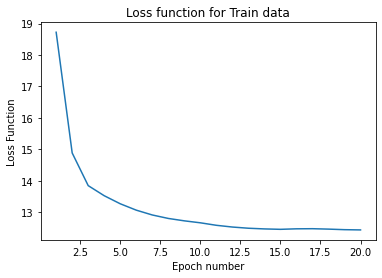

80.0


In [18]:
obj=neural_network(10)
obj.implem_NN()
obj.find_accuracy()

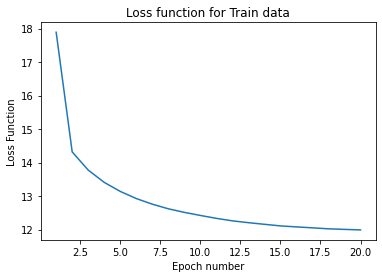

90.0


In [19]:
obj=neural_network(15)
obj.implem_NN()
obj.find_accuracy()

we can see that the accuracy increases as we increase the neurons in hidden layer from 10 to 15 this is because the neural network becomes more accurate if we increase the number of neurons in hidden layer